# Fashion mnist  - AutoEncoder for recommendation

이 노트에서는 패션아이템의 이미지데이터를 이용해 유사도에 기반한 아이템 추천 아이디어를 구현해보았습니다.

오토인코더를 이용해 이미지데이터를 2차원으로 축소한 후, 압축된 데이터(인코딩된 데이터)를 이용해 유클리디안 거리를 계산하였습니다.

아이템간 거리가 가까울수록 유사한 아이템이라고 가정하여 가장 가까운 아이템을 유사상품으로 추천하는 방식입니다.

----------
1-phase : 

    fashion mnist이미지를 autoencoder모델로 차원 축소시킨 후, 각 클래스별 분포를 확인함

2-phase :

    2-dim 인코딩된 데이터로 아이템간 유사도 측정을 수행함
    
3-phase : 
    
    모델의 성능을 평가함
    
In futre work, not this note :

    실제 패션 쇼핑몰의 아이템 이미지 데이터에 적용
_____________


In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance as dist
import random
import sklearn.metrics as metrics


np.random.seed(100)

encoding_dim = 2  

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


>### 모델 구조

> * 인풋레이어와 2개의 dense 레이어로 구성하였고, 학습해야할 파라미터는 3,922개임
> * 첫번째 dense레이어의 아웃풋은 본래 이미지(784차원)가 2차원으로 축소된 인코딩된 이미지(compressed representation)이고, 두번째 dense레이어의 아웃풋은 인코딩된 이미지를 다시 본래의 차원으로 재생산한 디코딩된 이미지(decompressed, or reconstructed input)임
> * 추후 모델 성능 개선을 위해 모델 구조를 변경할 수 있음. 여러개의 레이어를 추가하거나, convolutional 레이어와 같이 이미지의 특징을 추출하는데 적합한 레이러를 추가할 수 있음


> * 2차원 축소를 선택한 것은 아이템의 분포를 시각적으로 확인하기 위함임 (축소 비율 : 784/2=392)
> * 축소 비율이 적을수록 이미지가 가진 본래 특징에 대한 손실을 줄일 수 있지만, 시각적으로 분포를 확인하는 것이 어렵고 유사도 계산 단계에서 계산 비용이 늘어남.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.5279 - val_loss: 0.4475
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4339 - val_loss: 0.4279
Epoch 3/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4236 - val_loss: 0.4215
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4181 - val_loss: 0.4168
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4137 - val_loss: 0.4128
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4100 - val_loss: 0.4096
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.4069 - val_loss: 0.4066
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4041 - val_loss: 0.4042
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4016 - val_loss: 0.4019
Epoch

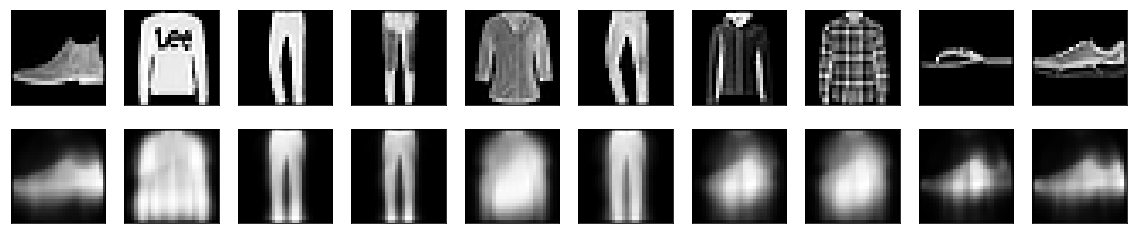

In [3]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

>### simple_AE 모델 학습 결과

>상 : fashion mnist 원본 이미지

>하 : AE모델에 의해 재생성(encoding->decoding)된 이미지

>* 재생성된 이미지의 경우, 대략적으로 물체를 알아볼 수있지만 디테일한 특징이 없어짐.
* 티셔츠와 바지의 차이는 구분할수 있지만, 앵클부츠와 샌들의 차이는 거의 구분할 수 없음

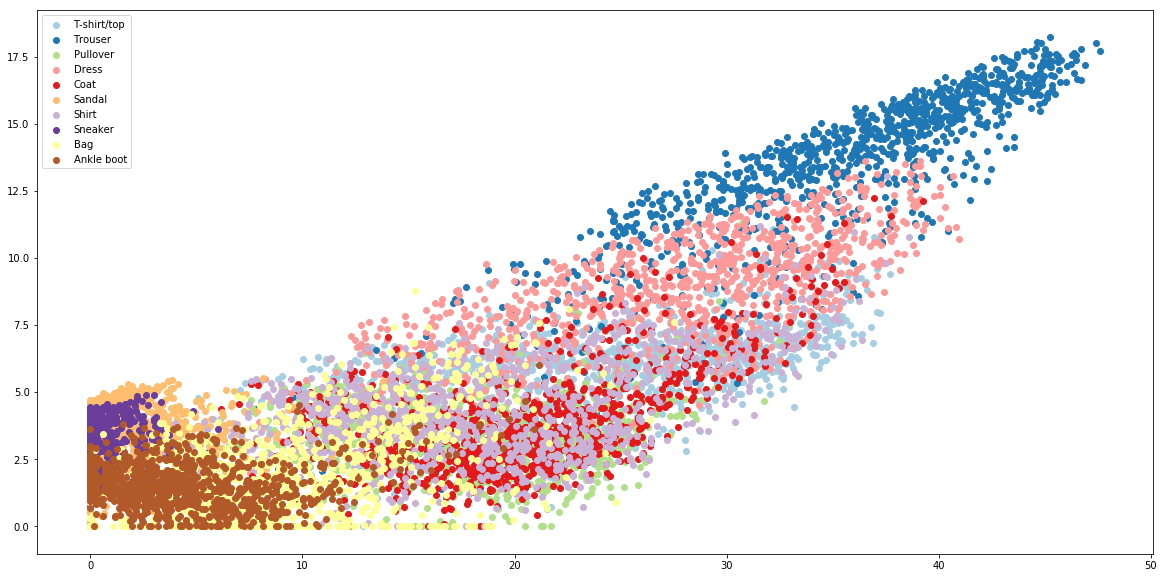

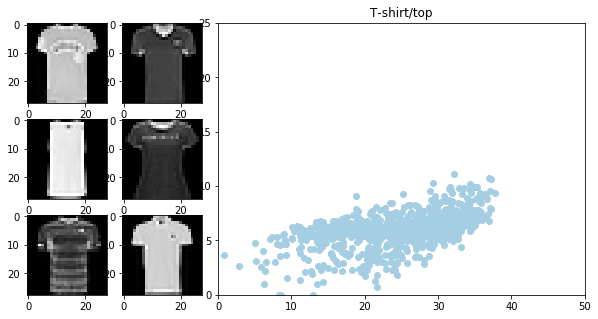

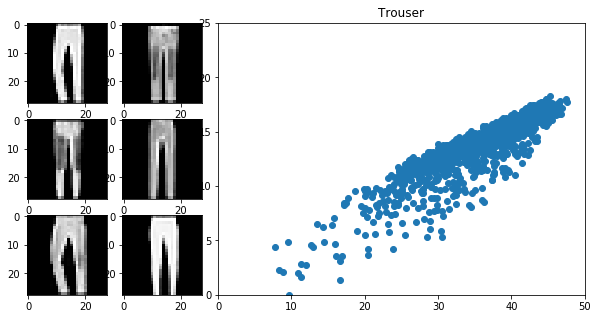

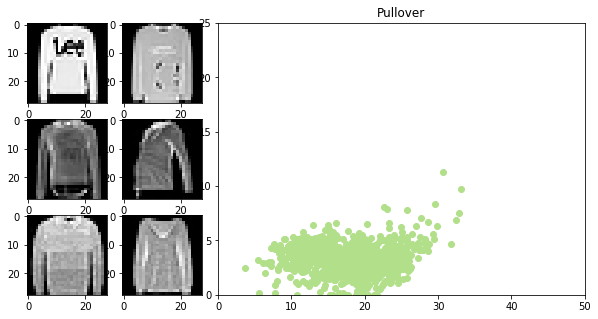

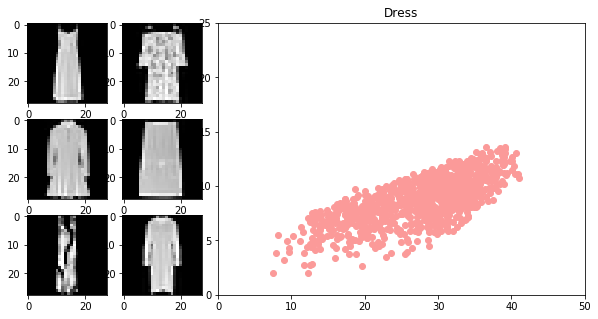

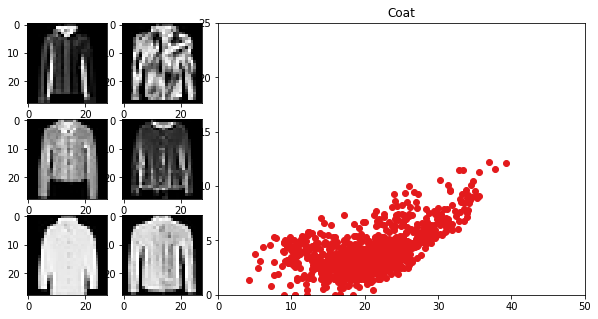

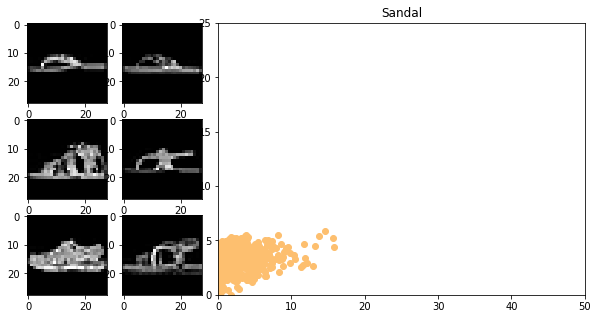

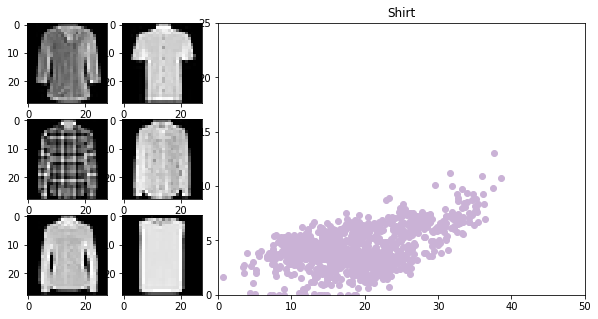

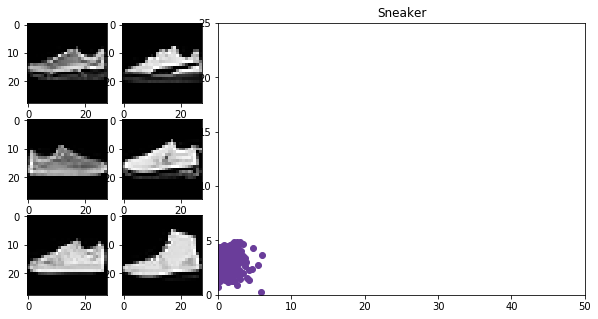

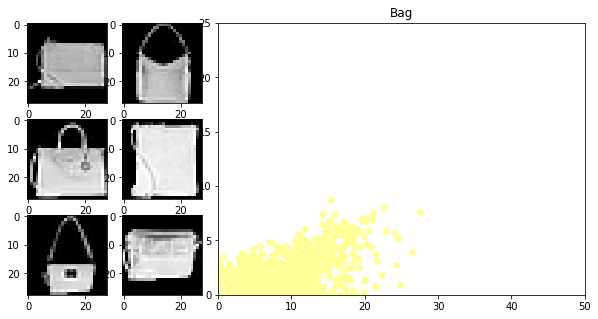

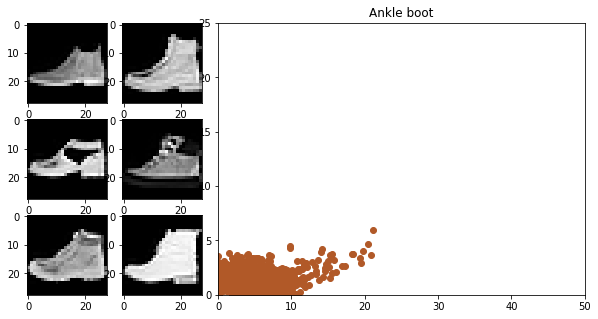

In [4]:
color_list = plt.cm.Paired(np.linspace(0, 1, 10))
items = ['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(20,10))
for j in range(10):
    ind = np.where(y_test==j)[0]
    plt.scatter(encoded_imgs[ind,0],encoded_imgs[ind,1], c=color_list[j, :])
plt.legend(items)
plt.show()


gridspec.GridSpec(3,3)

for i in range(10):
    ind = np.where(y_test==i)[0]
    plt.figure(figsize=(10,5))
    plt.subplot2grid((3,6), (0,2), colspan=4, rowspan=3)
    plt.scatter(encoded_imgs[ind,0],encoded_imgs[ind,1], c=color_list[i,:])
    plt.xlim(0,50)
    plt.ylim(0,25)
    plt.title(items[i])
    plt.subplot2grid((3,6), (0,0))
    plt.imshow(x_test[ind[0]].reshape(28,28))
    plt.subplot2grid((3,6), (1,0))
    plt.imshow(x_test[ind[1]].reshape(28,28))
    plt.subplot2grid((3,6), (2,0))
    plt.imshow(x_test[ind[2]].reshape(28,28))
    plt.subplot2grid((3,6), (0,1))
    plt.imshow(x_test[ind[3]].reshape(28,28))
    plt.subplot2grid((3,6), (1,1))
    plt.imshow(x_test[ind[4]].reshape(28,28))
    plt.subplot2grid((3,6), (2,1))
    plt.imshow(x_test[ind[5]].reshape(28,28))
    plt.show()
    

>### 인코딩된 이미지의 2차원 시각화
>
* 10종류의 아이템별 2차원 분포를 살펴봄

In [5]:
dist_mat = dist.squareform(dist.pdist(encoded_imgs, 'euclidean'))
np.fill_diagonal(dist_mat, np.inf)


>### 인코딩된 이미지간의 유사도 계산
>
* squareform으로 변경 후, 편의 상diagomal(자기 자신과의 거리) element는 inf로 변경

A item(left) and the closest item(right) : 
(4569, 2374)


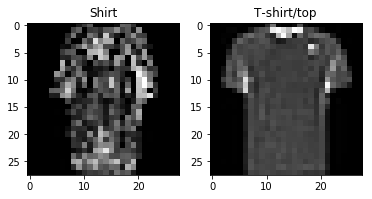

(949, 1728)


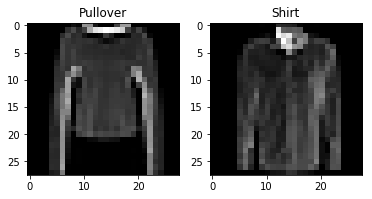

(69, 1931)


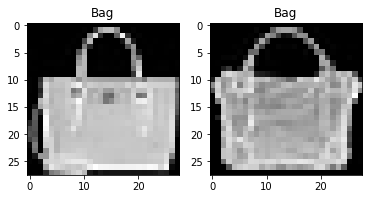

(2742, 4771)


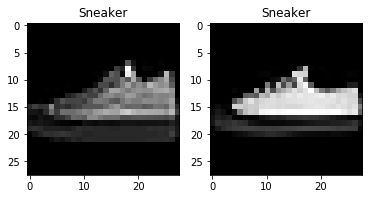

(1219, 9658)


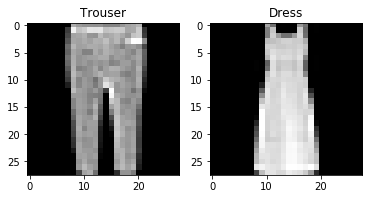

(7999, 8379)


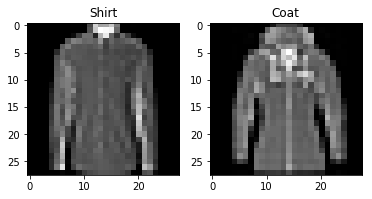

(9387, 4509)


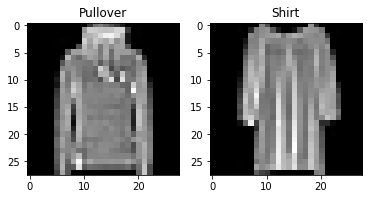

(7317, 748)


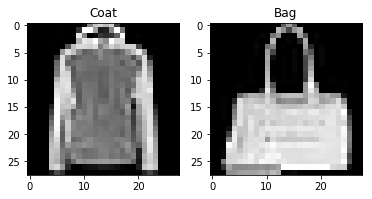

(3025, 874)


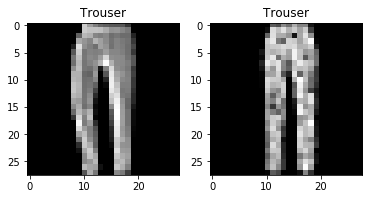

(705, 7277)


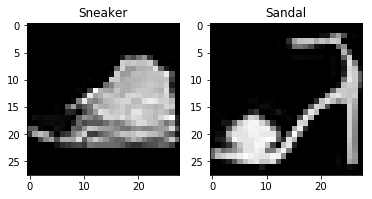

In [6]:
print("A item(left) and the closest item(right) : ")

for i in range(10):
    a_item = random.randrange(1,10000)
    closest_item = np.argmin(dist_mat[a_item,:])
    print(a_item, closest_item)
    plt.subplot(1,2,1)
    plt.imshow(x_test[a_item].reshape(28, 28))
    plt.title(items[y_test[a_item]])
    plt.subplot(1,2,2)
    plt.imshow(x_test[closest_item].reshape(28, 28))
    plt.title(items[y_test[closest_item]])
    plt.show()


>### 가장 유사한 아이템 선정
>
* 랜덤으로 특정 아이템을 선정한 후, 해당 아이템과 거리가 가장 가까운(=가장 유사한) 아이템을 찾음

In [7]:
closest_ind = np.argmin(dist_mat, axis=0)
recom_category = y_test[closest_ind]

accuracy = metrics.accuracy_score(y_test, recom_category)
report = metrics.classification_report(y_test, recom_category, target_names=items)
print("Accuracy : " + str(round(accuracy*100,2)) + "%\n")

print(report)

Accuracy : 45.07%

             precision    recall  f1-score   support

T-shirt/top       0.42      0.42      0.42      1000
    Trouser       0.78      0.79      0.78      1000
   Pullover       0.30      0.29      0.29      1000
      Dress       0.50      0.51      0.50      1000
       Coat       0.28      0.28      0.28      1000
     Sandal       0.52      0.52      0.52      1000
      Shirt       0.21      0.21      0.21      1000
    Sneaker       0.62      0.62      0.62      1000
        Bag       0.38      0.39      0.38      1000
 Ankle boot       0.49      0.50      0.49      1000

avg / total       0.45      0.45      0.45     10000



>### 성능 평가 : 같은 종류의 아이템을 추천하는 비율
>* 추천알고리즘의 성능을 평가하기 위해서는 사용자의 선호도 등 여러가지 방식의 평가가 필요함
>* 이 노트에서는 편의 상 '얼마나 유사한 아이템을 추천했느냐=같은 종류의 아이템을 추천했느냐'를 가지고 평가하고자 함


>* 테스트셋 1만개의 아이템 중 같은 종류의 아이템을 추천한 비율은 45.07%로 나타남
>* precision = 가장 유사한 상품이 (티셔츠)로 나타난 상품 중에서 실제 상품이 (티셔츠)인 경우
>* recall = (티셔츠) 상품에서 가장 유사한 상품이 (티셔츠)인 경우
>* precision과 recall의 조화평균으로 계산되는 f1-score기준으로, 아래 순으로 나타남

> trouser > Sneaker > Sandal > Dress > Ankle boot > T-shirt/top > Bag > Pullover > Coat > Shirt

> * f1-score가 가장 높은 trouser의 경우, 같은 카테고리 내에서 추천되는 비율이 높음. 모델을 통해서 trouser가 가지는 대표 특징이 비교적 잘 추출되었고 이를 통해 같은 속성을 가진 아이템을 추천하는 비율이 높은 것으로 판단됨
> * f1-score가 가장 낮은 Shirt의 경우, 같은 카테고리 내에서 추천되는 비율이 낮음. 모델을 통해 추출된 Shirt의 특징이 다른 아이템과 쉽게 구분되지 않아, 서로 다른 종류의 아이템을 추천하는 비율이 높은 것으로 판단됨

